In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from extract_data import get_column
from utility import get_data, get_spin

#### Get Start Time
The lines below are to help you get the start time for the launch. Guppy records continuously so a lot of unnecessary data is collected which would slow down the sim. We could get this number computationally but this is way easier :)


| Column Code | Value |
| ------ | ----- |
| 0 | time | 
| 1 | adxl x-accel | 
| 2 | adxl y-accel |
| 3 | axl1 z-accel | 
| 4 | bmi x-accel |
| 5 | bmi y-accel | 
| 6 | bmi z-accel |

In [2]:
file = open("15-2-2020-trim.txt")
time, accel = get_column(file, 2)
time = np.asarray(time)
accel = np.asarray(accel)

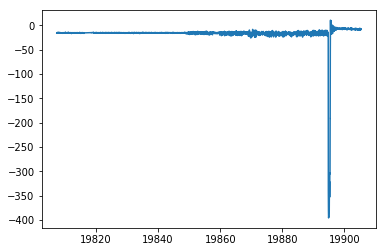

Approximately when does ignition occur: 19894
When did the rocket touch back down: 19896
Press q to stop: q


In [3]:
start = 0
end = len(accel)
while True:
    plt.plot(time[start:end], accel[start:end])
    plt.show()
    
    start = np.argmax(time > input("Approximately when does ignition occur: "))
    end = np.argmax(time > input("When did the rocket touch back down: "))
    
    if raw_input("Press q to stop: ") == 'q':
        break
        
time = np.asarray([x - time[start] for x in time[start:end]])
accel = accel[start:end] * -1

#### Model Environment
Acceleration data is used to get velocity, altitude, and air density. Check the graphs for accuracy

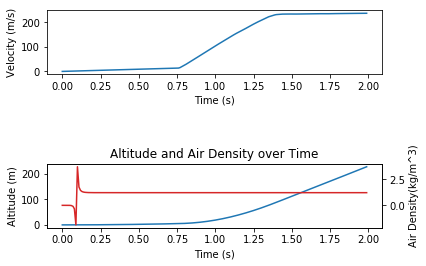

In [17]:
vel, altit, rho = get_data(time, accel)

plt.subplot(311)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.plot(time, vel, label='')

plt.subplot(313)
plt.plot(time, altit, label='altitude', color='tab:blue')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt2 = plt.twinx()
plt2.set_ylabel('Air Density(kg/m^3)')
plt.plot(time, rho, label='air density', color='tab:red')
plt.title('Altitude and Air Density over Time')

plt.show()

Using all of the information above we can calculate a *minimum* threshold for spin stability and compare it to the values recorded

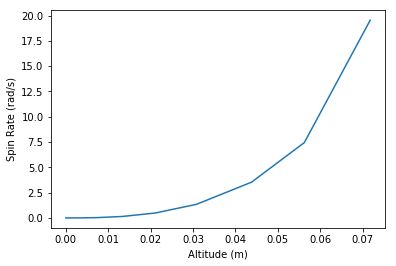

In [18]:
min_spin = get_spin(vel, rho)

plt.xlabel('Altitude (m)')
plt.ylabel('Spin Rate (rad/s)')
plt.plot(altit, min_spin)